In [7]:
import numpy as np
import yaml

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from collections import Counter
import operator as op

import os
from together import Together
%load_ext autoreload
%autoreload 2

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics

## Section 1: Existing CVs data analysis

Here is a recent collection of CVs from https://github.com/Stereotypes-in-LLMs/recruitment-dataset 
We will use these CVs as the basis for generating cover letters for our hiring model

In [5]:
df = pd.read_parquet('data/resumes.parquet', engine='pyarrow')  # raw dataframe

# Filter the dataframe minimum cv length
MIN_CV_LENGTH = 500
filtered_df = df.loc[df['CV'].dropna().apply(len) >= MIN_CV_LENGTH]

In [115]:
# See the top 20 most frequent positions
top20df = filtered_df.groupby("Position").count().sort_values("Moreinfo", ascending=False).head(20)
print(top20df)

                            Moreinfo  Looking For  Highlights  \
Position                                                        
Project Manager                 5299         2582        3298   
QA Engineer                     4886         2392        2577   
Junior QA Engineer              3333         1847        2206   
Front-end developer             3045         1602        1475   
Manual QA Engineer              2683         1243        1349   
UI/UX Designer                  2521         1303        1364   
Java Developer                  2246         1257        1167   
IT Recruiter                    1947          852         844   
Junior Front-end Developer      1861         1116        1270   
UX/UI Designer                  1771          967        1002   
Front-End Developer             1744          914         891   
Business Analyst                1710          794         947   
Python Developer                1509          835         821   
Product manager          

### True Labels (Positive and Negative Classes)

In [22]:
# Assign each entry in the filtered dataframe a label (0 for negative, 1 for positive)
POSITIVE_LABEL, NEGATIVE_LABEL = 1, 0

'''
Given a row of the dataframe, returns 
    1 if the entry belongs to the positive class
    0 if the entry belongs to the negative class
    NA if the entry is to be excluded
Can be thought of as "h" (although this function does not operate on a feature vector)

Currently, the positive class are entries where
   1. The primary keyword is "Project manager" (case insensitive) AND  
   2. The position contains "Project manager" (case insensitive),
while the negative class are entries where
   1. The primary keyword is "Java Developer" (case insensitive) AND  
   2. The position contains "Java Developer" (case insensitive),

Examine the effect of the second condition with
   print(labeled_df.loc[ (labeled_df["True Label"] == NEGATIVE_LABEL) & (labeled_df["Primary Keyword"] == PM) ])
'''
import re
def trueLabelFunction(row):
    # print(f"id = {row['id']}, Position = {row['Position']}, Primary Keyword = {row['Primary Keyword']}")
    
    POSITIVE_POSITION = "Project Manager"
    POSITIVE_KEYWORD = "Project Manager"

    NEGATIVE_POSITION = "QA Engineer"   # "Java Developer"
    NEGATIVE_KEYWORD = "QA"             # "Java"

    # Positive match
    positivePositionRegex = re.compile(f'.*{POSITIVE_POSITION}.*', re.IGNORECASE)
    isPositivePositionMatch: bool = isinstance(row["Position"], str) and bool(positivePositionRegex.match(row["Position"]))
    positivePrimaryKeywordRegex = re.compile(f'{POSITIVE_KEYWORD}', re.IGNORECASE)
    isPositivePrimaryKeywordMatch: bool = isinstance(row["Primary Keyword"], str) and bool(positivePrimaryKeywordRegex.match(row["Position"]))

    isPositiveMatch: bool = isPositivePositionMatch and isPositivePrimaryKeywordMatch

    # Negative match
    negativePositionRegex = re.compile(f'.*{NEGATIVE_POSITION}.*', re.IGNORECASE)
    isNegativePositionMatch: bool = isinstance(row["Position"], str) and bool(negativePositionRegex.match(row["Position"]))
    negativePrimaryKeywordRegex = re.compile(f'{NEGATIVE_KEYWORD}', re.IGNORECASE)
    isNegativePrimaryKeywordMatch: bool = isinstance(row["Primary Keyword"], str) and bool(negativePrimaryKeywordRegex.match(row["Position"]))

    isNegativeMatch: bool = isNegativePositionMatch and isNegativePrimaryKeywordMatch

    if isPositiveMatch:
        return POSITIVE_LABEL
    elif isNegativeMatch:
        return NEGATIVE_LABEL
    else:
        return pd.NA

# Creates a true label column
labeled_df = filtered_df.copy()
labeled_df["True Label"] = labeled_df.apply(trueLabelFunction, axis=1)
labeled_df = labeled_df[labeled_df["True Label"].notna()]       # Filter out rows whose label value is NA

In [24]:
# Prints the sizes of the positive and negative class
value_counts = labeled_df["True Label"].value_counts()
print(value_counts)

positiveClassSize = value_counts.get(POSITIVE_LABEL, default=0)
negativeClassSize = value_counts.get(NEGATIVE_LABEL, default=0)
# print(f"positiveClassSize = {positiveClassSize}")
# print(f"negativeClassSize = {negativeClassSize}")
print(f"proportion of positives = {positiveClassSize / (positiveClassSize + negativeClassSize)}")

True Label
1    6753
0    6379
Name: count, dtype: int64
proportion of positives = 0.5142400243679561


In [29]:
# Example positive entry 
examplePositiveEntry = labeled_df.loc[labeled_df["True Label"] == POSITIVE_LABEL].iloc[0]
print(examplePositiveEntry.to_dict()["CV"])
# print("".join(examplePositiveEntry.to_dict()['CV'].split('\r\n')).split('\n'))

High levels of self-organization, structure, and attention to detail have helped build a successful career in advertising, as evidenced by hundreds of successfully completed projects, and train dozens of specialists. Previous experience is similar to project management methodologies used in the IT industry, including budgeting, planning, stakeholder management, risk mitigation, and effective communication. Creating new products inspires and motivates further development.
Account director
2018 - 2021
Management and development of client portfolio. 
Control over project development and progress. 
Planning and budgeting based on client portfolio. 
Analysis of project effectiveness and profitability. 
Operational management: organizing, coordinating, and controlling the work of the account team (planning and task allocation). 
Ensuring effective interaction of the account managers team between agency departments.

Senior account manager 
2017 - 2018
Communication with clients. 
Budgeting. 

In [32]:
# Example negative entry 
exampleNegativeEntry = labeled_df.loc[labeled_df["True Label"] == NEGATIVE_LABEL].iloc[10]
print(exampleNegativeEntry.to_dict()["CV"])
# print("".join(exampleNegativeEntry.to_dict()['CV'].split('\r\n')).split('\n'))


June/2022 - Present
- Experience with QA/Web tools (bug-reports, check-lists, documentation writing, writing/ updating test cases, testing with a database(postgresql), testing API requests, GitHub, TeamCity);
- Experience with a Regression tests, Integration, Functional tests, End-to-end, Acceptance, Smoke, Stress;
- Experience with Automation tools (JS/ Playwright, test coverage (UI, API, Database));
- Experience and understanding of Agile Development methodologies especially Scrum.

December/2021 - June/2022
- Experience with QA/Web tools (bug-reports, check-lists, writing/updating test cases, testing API requests, GitHub);
μ Experience with Automation tools (JS/Cypress, test coverage (UI, API));
- Experience with a Regression tests, Integration, Functional tests, End-to-end, Acceptance, Smoke;
- Experience and understanding of Agile Development methodologies especially Kanban.

November/2021 - December/2021
- Experience with QA/mobile tools(bug-reports, check-lists);
- Experience w

In [7]:
## TODO: further explorations of CV data, bring 2-3 insights about the CV itself and Insights and highlights

#First: What words are used more? Collaboration base Terms or Technical terms?

def plot_position_words(position):
    pm_occupation_df = df[df["Position"]==position]
    all_cvs = "\n".join(list(pm_occupation_df['CV']))
    all_words = all_cvs.split(" ")
    all_long_words = [word for word in all_words if len(word) > 10]
    word_counts = Counter(all_long_words)
    top_ten = word_counts.most_common(20)
    words =  [item[0] for item in top_ten]
    counts = [item[1]/len(pm_occupation_df) for item in top_ten]
    #fig, ax = plt.subplots(figsize =(10, 6))
    return [words, counts]
    # Horizontal Bar Plot
    #ax.barh(words, counts)
    #ax.set_title('Frequency of Words in ' + position + " CVs",loc ='left', )
    #ax.invert_yaxis()
 
#plot_position_words("Java Developer")

#fig, axs = plt.subplots(4, 5, figsize=(100, 100))
#fig.suptitle('Word Frequencies')

'''
for i in range(0, len(top_twenty_jobs)):
    print(top_twenty_jobs[i])
    plot_position_y = i % 4
    plot_position_x = i%5
    print(plot_position_y, plot_position_x)
    axs[plot_position_y, plot_position_x].set_title('Frequency of Words in ' + top_twenty_jobs[i] + " CVs",loc ='left', )
    axs[plot_position_y, plot_position_x].invert_yaxis()
    axs[plot_position_y, plot_position_x].barh(plot_position_words(top_twenty_jobs[i])[0], plot_position_words(top_twenty_jobs[i])[1])
fig.savefig("word-frequncies.png")
'''


'for i in range(0, len(top_twenty_jobs)):\n    print(top_twenty_jobs[i])\n    plot_position_y = i % 4\n    plot_position_x = i%5\n    print(plot_position_y, plot_position_x)\n    axs[plot_position_y, plot_position_x].set_title(\'Frequency of Words in \' + top_twenty_jobs[i] + " CVs",loc =\'left\', )\n    axs[plot_position_y, plot_position_x].invert_yaxis()\n    axs[plot_position_y, plot_position_x].barh(plot_position_words(top_twenty_jobs[i])[0], plot_position_words(top_twenty_jobs[i])[1])\nfig.savefig("word-frequncies.png")'

## Section 2: Prompting LLMs for generating cover letters 

Now we will use a generic prompt to generate a cover letters for each resume using API calls

In [8]:
# Load the YAML file
with open('llm_api_keys.yaml', 'r') as file:
    config = yaml.safe_load(file)

together_api_key = config['services']['together']['api_key'] # replace with openai or anthropic also in yaml file

In [12]:
# # example usage of Together AI 
# client = Together(api_key=together_api_key) 
# position = "Project Manager"


# response = client.chat.completions.create(
#     model="mistralai/Mixtral-8x7B-Instruct-v0.1",
#     messages=[{"role": "user", "content": "Modify this resume to help me get a "+ position+" Job:" + "".join("".join(java_dev_occupation_df.iloc[0].to_dict()['CV'].split('\r\n')).split('\n'))}],
# )
coverletter = response.choices[0].message.content

In [13]:
print(coverletter)

 [Your Name]
[Address]
[City, State ZIP]
[Phone Number]
[Email Address]

PROFESSIONAL EXPERIENCE

Project Manager, LLC "ЕКО" (supermarkets ЕКО), [City, State]
September 2017 - Present

* Oversee project management of modernization, automation, reconstruction, and construction of trade objects, ensuring timely delivery and adherence to consolidated budgets.
* Collaborate with project members, contractors, and suppliers, fostering strong relationships and effective communication.
* Organize meetings and present projects, utilizing technology, visualization, and business plans to effectively convey project details and objectives.
* Develop architectural drawings and technical specifications for supermarkets and shopping centers using AutoCAD.

IT Support Specialist, PE "SoloService", [City, State]
May 2018 - October 2018

* Provided user support for computer systems and user applications, including website, mobile app, intranet, Outlook, Skype, operating systems (Windows and Linux).
* Ins

In [19]:
# Script to generate resumes

df = pd.read_parquet('data/resumes.parquet', engine='pyarrow')

java_dev_occupation_df = df[df["Position"]=="Java Developer"]


with open('llm_api_keys.yaml', 'r') as file:
    config = yaml.safe_load(file)

together_api_key = config['services']['together']['api_key'] # replace with openai or anthropic also in yaml file

df = pd.read_parquet('data/resumes.parquet', engine='pyarrow')

java_dev_occupation_df = df[df["Position"]=="Java Developer"]

def create_modified_resumes(unmodifiedresumes, num_of_resumes, originalposition):
    # example usage of Together AI 
    modifiedresumes = []
    for resume in unmodifiedresumes[0:num_of_resumes]:
        client = Together(api_key=together_api_key) 
        position = "Project Manager"
        response = client.chat.completions.create(
            model="mistralai/Mixtral-8x7B-Instruct-v0.1",
            messages=[{"role": "user", "content": "Modify the following resume to help me get a "+ position+" Job:" + resume}],
        )

        #Trim out the AI conversation (I hope this faldskraewr! stuff).
        output = response.choices[0].message.content
        output = output[output.find("\n"):output.rfind('\n')]
        output = "".join("".join(output.split('\r\n')).split('\n'))
        modifiedresumes.append(output)

    with open(originalposition+'to'+position+'.txt', 'w') as f:
        for resume in modifiedresumes:
            f.write(f"{resume}\n")
    return modifiedresumes

java_to_pm_mod_resume = create_modified_resumes(list(java_dev_occupation_df['CV']), 2, "java")

## Section 3: Training a simple hiring model 

We will now use fast text to create a hiring model which will make a binary decision of whether we should hire a candidate or not based on years of experience as the ground truth. Fasttext (https://fasttext.cc/) is an easy to use library you can run on your local computer to build text classification models or get embedding representations for different inputs. Here we will use Fast text to generate embeddings and then use a logistic classifier on top of it. 

### Step 1: Generate embeddings from cover letters 

In [1]:
# Load fast text vectors
import fasttext
FASTTEXT_MODEL_FILEPATH = "./cc.en.300.bin"      # '../../../Downloads/cc.en.300.bin'
ft = fasttext.load_model(FASTTEXT_MODEL_FILEPATH) # replace with your own path to the vector binary

In [5]:
# Get the vector representation of a multiword string using fasttex embeddings
def get_vector_rep(text: str): 
    tokens = text.lower().split() # feel free to use other tokenizations if you want
    
    if len(tokens) == 0:
        print(tokens)
        print(text)
        print(len(text))
    
    for (i, t) in enumerate(tokens):
        if i == 0:
            vec = ft.get_word_vector(t)
        else:
            vec += ft.get_word_vector(t)
    
    return vec

In [8]:
metrics.pairwise.cosine_similarity(get_vector_rep("hi there"), get_vector_rep("hi there"))

ValueError: Expected 2D array, got 1D array instead:
array=[ 6.65096343e-01  2.97521979e-01 -1.56501085e-01 -3.20311114e-02
  1.02320775e-01  9.82945263e-02 -1.37315482e-01  7.56987184e-02
 -2.90368497e-02  9.50071067e-02 -4.98840585e-02 -1.11668162e-01
 -1.45613089e-01  2.01136600e-02  6.15814805e-01  5.79249561e-02
  1.76063217e-02 -1.67158395e-01 -5.03732681e-01  1.06411785e-01
 -1.04566783e-01  5.29098287e-02 -3.93239483e-02 -1.60272151e-01
  3.13361228e-01 -5.90669066e-02 -8.40449855e-02 -6.16185479e-02
 -3.13426226e-01  8.82991493e-01 -5.59248984e-01 -1.32487148e-01
  5.52973859e-02 -4.45944294e-02 -1.54496863e-01 -3.30258645e-02
  2.32216537e-01  1.09668106e-01 -3.99696678e-01  5.08982129e-02
  1.08615179e-02 -3.04671228e-01 -3.24401230e-01  3.93968999e-01
  2.72737861e-01  3.14308465e-01 -7.37862885e-02  3.35593700e-01
 -1.78678021e-01  2.69883037e-01  1.88951626e-01 -3.99603724e-01
  5.27728796e-01  4.39980358e-01 -1.22266650e-01 -2.51271069e-01
 -2.09920913e-01  3.26351553e-01  9.30646658e-02  3.53962108e-02
 -9.54053849e-02  2.85367578e-01 -2.04983190e-01  6.08390756e-02
  5.20449579e-01  3.66918266e-01 -3.62423897e-01  4.33130115e-02
  3.42745066e-01 -2.35036984e-01  2.50606626e-01 -2.60355145e-01
 -1.58054799e-01 -2.57280767e-01 -2.09777623e-01  1.26717150e-01
 -3.28733534e-01  2.54562404e-02  4.22961235e-01  5.47181219e-02
 -1.57864198e-01  6.57370612e-02  1.09109730e-01  4.31963056e-01
  2.95211207e-02 -2.08288282e-01  1.31193012e-01  1.30579308e-01
 -4.53440487e-01 -6.28382206e-01 -4.68102366e-01 -8.74839425e-02
  6.38182104e-01 -8.99044350e-02  1.77155405e-01 -1.99858561e-01
  2.25623056e-01  1.54751241e-01 -6.54192045e-02  1.30125612e-01
 -3.07556480e-01 -4.21925262e-02  4.85155910e-01 -1.93830416e-01
  3.85669433e-02 -2.06941068e-01 -1.59926519e-01  1.35670267e-02
  1.27840899e-02 -5.76183908e-02  3.56957138e-01 -1.80732578e-01
 -3.14748049e-01  3.71541619e-01  8.67034495e-02 -3.94166350e-01
  1.52965546e-01  3.20536941e-01 -8.33948255e-01  1.73846215e-01
 -3.15447785e-02  2.53877521e-01 -7.76640177e-02  7.13011324e-02
  5.62251210e-02 -1.71179354e-01  3.18755120e-01 -1.34080946e-01
 -1.62658244e-02 -1.29518658e-01  1.96555704e-01 -2.27488533e-01
 -8.06676820e-02 -1.48555875e-01 -3.06881554e-02 -3.15281272e-01
 -1.91197723e-01  4.53890830e-01 -2.91798472e-01 -3.97584140e-02
 -1.27895981e-01  4.16696131e-01  1.35093089e-03  2.49832906e-02
  4.68103513e-02  6.23395145e-02 -9.63391066e-01  2.14227095e-01
  2.44988844e-01  3.83288443e-01 -3.18860114e-01 -5.87553978e-01
 -3.44077647e-01 -1.41598731e-01 -5.49800061e-02 -1.40233159e-01
  1.34856015e-01 -3.66223603e-02  3.39073204e-02 -1.41930073e-01
 -3.28329921e-01  2.59207524e-02 -3.09753194e-02 -4.91268933e-01
  5.77615201e-01 -3.23589504e-01  6.43398017e-02 -1.23584069e-01
 -1.67372197e-01 -2.64397353e-01  2.82805767e-02 -1.39255390e-01
 -1.52861282e-01  5.62726706e-02 -7.08682835e-02 -1.32154375e-01
  5.08894883e-02  2.39494979e-01  1.69523224e-01 -2.04753891e-01
  5.53456306e-01  3.56753081e-01 -2.29304790e-01  3.85362625e-01
  3.24098945e-01  1.52554899e-01  3.60159427e-01  1.43698454e-01
  2.73998082e-02 -1.34890378e-01 -1.35501683e-01 -4.23135757e-01
  1.77232280e-01 -4.04924631e-01 -8.47555771e-02  1.08880371e-01
 -1.51582077e-01  3.03629339e-01  1.97714463e-01  2.41824493e-01
 -1.73799902e-01  4.17532504e-01  4.43565659e-03 -1.57998037e-02
 -3.31009105e-02 -5.69732934e-02 -2.60301493e-02  1.34424180e-01
 -2.07603276e-01  1.14401311e-01  1.84303179e-01  8.27037394e-02
 -3.64330649e-01  8.65249336e-03  1.77843451e-01 -7.37874955e-02
  2.45228440e-01 -1.50729552e-01 -1.17254891e-01  5.05934954e-02
 -5.42139888e-01  4.55219060e-01 -1.39448896e-01 -7.24543035e-02
 -1.67072892e-01 -2.39521876e-01 -2.72780597e-01 -3.80059451e-01
 -3.38007689e-01  2.93894887e-01 -8.78773630e-04  2.98647553e-01
  2.49857008e-01 -3.90624166e-01  9.96749640e-01  1.35030478e-01
  1.03109673e-01  6.35792911e-01 -4.66597080e-01 -2.26724744e-02
 -3.09081562e-02 -1.46316081e-01  7.67740428e-01  9.20861959e-03
  1.01717699e+00 -2.17770338e-02 -1.26157120e-01  3.25635910e-01
 -3.28922719e-01  1.20332703e-01  5.92517436e-01 -4.90000136e-02
  2.43612275e-01  7.62217678e-04 -1.72965005e-02  2.92371541e-01
  3.78475308e-01  2.44698972e-02  8.46535563e-02  1.07676849e-01
  3.68385911e-01  7.09267855e-02 -6.18020594e-01 -1.39917836e-01
  1.87790096e-01  7.54140988e-02 -3.65676552e-01  1.83863252e-01
 -5.99421918e-01 -4.26096290e-01  3.41905475e-01 -3.92842442e-01
  7.09362179e-02  1.56611979e-01  1.57824591e-01 -6.38018698e-02
  1.24118902e-01 -1.49945244e-02  3.73256579e-02 -2.93892138e-02
 -7.14433074e-01  8.84225406e-03 -6.04949594e-01 -1.19037233e-01
  6.10650666e-02  1.79518819e-01  3.17005783e-01 -5.87109387e-01
 -9.80643779e-02  9.94379371e-02  3.93209517e-01  3.37677300e-01
 -1.11472428e+00  2.49414206e-01  4.23687398e-01 -1.14322700e-01
  3.50465834e-01  6.59767687e-01 -2.50891894e-01  1.77685134e-02].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [22]:
datasets = {0:list(java_dev_occupation_df['CV']), 1: list(pm_occupation_df['CV'])}

vector_rep = get_vector_rep("".join("".join(java_dev_occupation_df.iloc[0].to_dict()['CV'].split('\r\n')).split('\n')))

In [23]:
def create_test_train_dataset(true_dataset, false_dataset):
    x_s = []
    y_s = []
    for cv_s in true_dataset:
        x_s.append(get_vector_rep("".join("".join(cv_s.split('\r\n')).split('\n'))))
        y_s.append(1)
    for cv_s in false_dataset:
        x_s.append(get_vector_rep("".join("".join(cv_s.split('\r\n')).split('\n'))))
        y_s.append(0)
    return [x_s, y_s]

In [24]:
"".join("".join(datasets[0][0].split('\r\n')).split('\n'))

'01.11.2018   PE «SoloService»Position: Java Developer.• Software design, investigating technical solutions• Reviewing project documentation, analyzing requirements• Troubleshoot and analyze problems identified in the system software04.05.2018 – 31.10.2018   PE «SoloService» Position: IT Support Specialist.• provide user support for computer systems and user applications, including: website, mobile app, intranet, Outlook, Skype, operating systems (Windows and Linux);• installing and configuring computer hardware, software, mobile devices, video projection systems and audio systems;26.09.2017 – 03.05.2018   LLC «ЕКО» (supermarkets ЕКО)Position: Head of Project department.• project management of modernization, automation, reconstruction and  construction of trade objects;• to control the timing of project delivery;• establishment of consolidate budgets of projects;• organization of meetings, presentation of project (technology, visualization, business plan);• collaboration with project m

In [25]:
# TODO: build vector embeddings and lables for positive label examples experience more than 5 years, negative examples less than 5
training_data = create_test_train_dataset(datasets[1], datasets[0])

### Step 2: Build classifier for resume classification

In [26]:
no_applicant_modification_data = [training_data[0], training_data[1]]

In [27]:
#Generates (model, x_test, y_test) based on input (x, y) data
def train_model(data):
    x = data[0]
    y=data[1]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    clf = LogisticRegression(random_state=16)
    clf.fit(x_train, y_train)

    p = clf.predict_proba(x_test)[:, 1]
    p_acc = accuracy_score(y_test, p > 0.5)
    print("clf_acc", p_acc)
    return [clf, x_test, y_test]

#Plots confusion matrix
def plot_conf_matrix(xtest, ytest, output_model):
    cnf_matrix = metrics.confusion_matrix(ytest, output_model.predict(xtest))
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion Matrix', y=1.1)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')

In [81]:
test_resumes = []

with open("javadeveloper_to_pm.text", 'r') as f:
    for line in f:
        if len(line) >1:
            test_resumes.append(get_vector_rep(line))
        #print("new")


## Section 4: Simulation manipulations and evaluate disparity 

In [ ]:
test_resumes = []

with open("javadeveloper_to_pm.text", 'r') as f:
    for line in f:
        if len(line) >1:
            test_resumes.append(get_vector_rep(line))

/Users/ch/miniforge3/envs/llm_jobs/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


clf_acc 0.9648780487804878
Intercept: [-0.34687288]


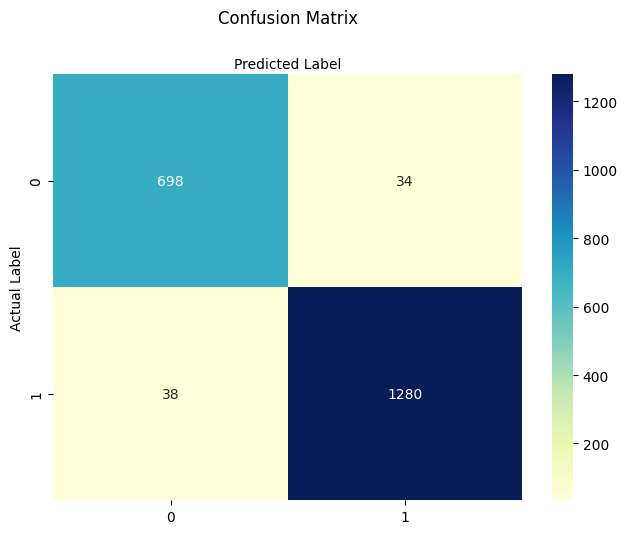

In [160]:
#Question 1: Let's train a model on just the non-modified resumes. Does modify the Java SWE resumes increase the chance of acceptance?

#train model on unmodified data
model_output = train_model(no_applicant_modification_data)
print('Intercept: {0}'.format(model_output[0].intercept_))
plot_conf_matrix(model_output[1], model_output[2], model_output[0])

In [161]:
#Predict on modified JAVA SWE data. Do these "0" datapoints became incorrectly labeled as 1?
java_predictions = model_output[0].predict(test_resumes)
ratiooffalsepositives = len([i for i in java_predictions if i==1])/len(java_predictions)
print("THe ratio of FP in the Java SWE modified data, amongst all the JAVA SWE is", ratiooffalsepositives, ".")

THe ratio of FP in the Java SWE modified data, amongst all the JAVA SWE is 0.22795153564384332 .


In [ ]:
#train model on unmodified data
model_output = train_model(no_applicant_modification_data)
print('Intercept: {0}'.format(model_output[0].intercept_))
plot_conf_matrix(model_output[1], model_output[2], model_output[0])

In [158]:
datasets[0] = test_resumes

In [170]:
with open("javadeveloper_to_pm.text", 'r') as f:
    for line in f:
        print(line)
        break

**[Your Name]****Contact Information:**[Include your contact information here]**Summary:**Experienced Project Manager with a proven track record of delivering projects on time and within budget. Skilled in project management, team leadership, and technical problem-solving. Proficient in AutoCAD, Windows, and Linux.**Experience:****Project Manager, LLC "ЕКО" (supermarkets ЕКО)***26.09.2017 – 03.05.2018** Managed the modernization, automation, reconstruction, and construction of trade objects, ensuring timely delivery and consolidated budgets.* Organized meetings and presented project technology, visualization, and business plans.* Collaborated with project members, contractors, and suppliers to ensure project success.**Chief Design Engineer, Project Department, LLC "ЕКО" (supermarkets ЕКО)***20.04.2012 – 25.09.2017** Developed architectural drawings and technical specifications for supermarkets and shopping centers in AutoCAD.* Collaborated with project managers to ensure project succes